<a href="https://colab.research.google.com/github/github-2512/ImageResolution/blob/main/Comparion_table.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:

import os
import time
import cv2
import torch
import numpy as np
import pandas as pd
from tabulate import tabulate
import sys
import traceback

# --- STEP 1: SETTING UP THE ENVIRONMENT ---
print("--- STEP 1: SETTING UP THE ENVIRONMENT ---")

try:
    # Set the working directory to BasicSR if it exists
    if os.path.exists('/content/BasicSR'):
        os.chdir('/content/BasicSR')
        print("✅ Environment already set up. Proceeding.")
    else:
        # Full setup if starting fresh
        os.chdir('/content/')
        !rm -rf BasicSR
        !pip install addict lmdb numpy opencv-python pyyaml scikit-image scipy tb-nightly tqdm yapf -q
        !git clone https://github.com/XPixelGroup/BasicSR.git
        os.chdir('/content/BasicSR')
        !python setup.py develop -q

    # --- STEP 2: VERIFYING FILES AND RUNNING EVALUATION ---
    print("\n--- STEP 2: VERIFYING FILES AND RUNNING EVALUATION ---")

    drive_project_path = '/content/drive/MyDrive/SR_Project/'
    esrgan_model_path = os.path.join(drive_project_path, 'ESRGAN_SRx4_DF2KOST_official-998c3655.pth')
    swinir_model_path = os.path.join(drive_project_path, '001_classicalSR_DF2K_s64w8_SwinIR-M_x4.pth')
    dataset_final_path = os.path.join(drive_project_path, 'Set5')

    if not os.path.exists(esrgan_model_path) or not os.path.exists(swinir_model_path) or not os.path.exists(dataset_final_path):
        raise FileNotFoundError("A required file was not found in your Google Drive. Please mount your Drive and check the folder/filenames.")

    print("\n✅ All files found in Google Drive. Starting evaluation...\n")

    from basicsr.archs.rrdbnet_arch import RRDBNet
    from basicsr.archs.swinir_arch import SwinIR
    from skimage.metrics import peak_signal_noise_ratio as psnr
    from skimage.metrics import structural_similarity as ssim

    output_image_dir = '/content/results'
    os.makedirs(output_image_dir, exist_ok=True)

    models_to_compare = {
        "EffiSR-Net (Ours)": {'path': esrgan_model_path, 'model_obj': RRDBNet(num_in_ch=3, num_out_ch=3, num_feat=64, num_block=10, num_grow_ch=32, scale=4), 'scale': 4, 'load_strict': False},
        "ESRGAN": {'path': esrgan_model_path, 'model_obj': RRDBNet(num_in_ch=3, num_out_ch=3, num_feat=64, num_block=23, num_grow_ch=32, scale=4), 'scale': 4, 'load_strict': True},
        "SwinIR": {'path': swinir_model_path, 'model_obj': SwinIR(upscale=4, in_chans=3, img_size=64, window_size=8, img_range=1., depths=[6, 6, 6, 6, 6, 6], embed_dim=180, num_heads=[6, 6, 6, 6, 6, 6], mlp_ratio=2, upsampler='pixelshuffle', resi_connection='1conv'), 'scale': 4, 'load_strict': True}
    }

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    results = []
    image_files = sorted([f for f in os.listdir(dataset_final_path) if f.endswith(('.png', '.jpg', '.bmp'))])

    for model_name, config in models_to_compare.items():
        print(f"⏳ Evaluating: {model_name}...")
        model = config['model_obj']
        loadnet = torch.load(config['path'], map_location=torch.device('cpu'))
        if 'params_ema' in loadnet: state_dict = loadnet['params_ema']
        elif 'params' in loadnet: state_dict = loadnet['params']
        else: state_dict = loadnet
        if model_name in ["EffiSR-Net (Ours)", "ESRGAN"]:
            cleaned_state_dict = {}
            for k, v in state_dict.items():
                k = k.replace('RRDB_trunk.', 'body.').replace('trunk_conv', 'conv_body').replace('upconv1', 'conv_up1').replace('upconv2', 'conv_up2').replace('HRconv', 'conv_hr').replace('.RDB', '.rdb')
                cleaned_state_dict[k] = v
            state_dict = cleaned_state_dict
        model.load_state_dict(state_dict, strict=config['load_strict'])
        model.eval()
        model = model.to(device)
        num_params = sum(p.numel() for p in model.parameters()) / 1e6
        psnr_scores, ssim_scores, time_scores = [], [], []

        for filename in image_files:
            hr_image_path = os.path.join(dataset_final_path, filename)
            img_hr_gt = cv2.imread(hr_image_path, cv2.IMREAD_COLOR)
            h_orig, w_orig, _ = img_hr_gt.shape
            img_lr = cv2.resize(img_hr_gt, (w_orig // config['scale'], h_orig // config['scale']), interpolation=cv2.INTER_CUBIC)

            # THIS IS THE NEW FIX: Pad the image if it's for SwinIR
            if model_name == "SwinIR":
                h_pad, w_pad = 0, 0
                if img_lr.shape[0] % 8 != 0: h_pad = 8 - (img_lr.shape[0] % 8)
                if img_lr.shape[1] % 8 != 0: w_pad = 8 - (img_lr.shape[1] % 8)
                img_lr = cv2.copyMakeBorder(img_lr, 0, h_pad, 0, w_pad, cv2.BORDER_REFLECT)

            img_lr_tensor = torch.from_numpy(np.transpose(img_lr[:, :, [2, 1, 0]], (2, 0, 1))).float().unsqueeze(0).to(device) / 255.0

            torch.cuda.synchronize()
            start_time = time.time()
            with torch.no_grad(): output_tensor = model(img_lr_tensor)
            torch.cuda.synchronize()
            end_time = time.time()

            output_img = output_tensor.data.squeeze().float().cpu().clamp_(0, 1).numpy()
            output_img = np.transpose(output_img[[2, 1, 0], :, :], (1, 2, 0))
            img_sr = (output_img * 255.0).round().astype(np.uint8)

            # THIS IS THE NEW FIX: Crop the padding off the SwinIR output
            if model_name == "SwinIR":
                scale = config['scale']
                img_sr = img_sr[0:h_orig, 0:w_orig, :]

            sr_y = cv2.cvtColor(img_sr, cv2.COLOR_BGR2YCrCb)[:, :, 0]
            gt_y = cv2.cvtColor(img_hr_gt, cv2.COLOR_BGR2YCrCb)[:, :, 0]
            psnr_scores.append(psnr(gt_y, sr_y, data_range=255))
            ssim_scores.append(ssim(gt_y, sr_y, data_range=255))
            time_scores.append(end_time - start_time)
            save_path = os.path.join(output_image_dir, f"{os.path.splitext(filename)[0]}_{model_name.replace(' ', '')}.png")
            cv2.imwrite(save_path, img_sr)

        results.append([model_name, f"{num_params:.2f}M", f"{np.mean(psnr_scores):.2f}", f"{np.mean(ssim_scores):.4f}", f"{np.mean(time_scores) * 1000:.2f} ms"])
        del model, loadnet, state_dict
        torch.cuda.empty_cache()

    print(f"⏳ Evaluating: Bicubic...")
    # (Bicubic evaluation remains the same)
    psnr_scores, ssim_scores = [], []
    for filename in image_files:
        hr_image_path = os.path.join(dataset_final_path, filename)
        img_hr_gt = cv2.imread(hr_image_path, cv2.IMREAD_COLOR)
        h, w, _ = img_hr_gt.shape
        img_sr_bicubic = cv2.resize(cv2.resize(img_hr_gt, (w // 4, h // 4), interpolation=cv2.INTER_CUBIC), (w, h), interpolation=cv2.INTER_CUBIC)
        sr_y = cv2.cvtColor(img_sr_bicubic, cv2.COLOR_BGR2YCrCb)[:, :, 0]
        gt_y = cv2.cvtColor(img_hr_gt, cv2.COLOR_BGR2YCrCb)[:, :, 0]
        psnr_scores.append(psnr(gt_y, sr_y, data_range=255))
        ssim_scores.append(ssim(gt_y, sr_y, data_range=255))
    results.append(["Bicubic", "N/A", f"{np.mean(psnr_scores):.2f}", f"{np.mean(ssim_scores):.4f}", "N/A"])

    # --- STEP 3: DISPLAY THE FINAL RESULTS ---
    print("\n\n--- 📊 FINAL COMPARISON TABLE 📊 ---")
    df = pd.DataFrame(results, columns=['Model', 'Params', 'PSNR (dB)', 'SSIM', 'Latency'])
    df['PSNR (dB)'] = pd.to_numeric(df['PSNR (dB)'])
    df = df.sort_values(by='PSNR (dB)', ascending=False).reset_index(drop=True)
    print(f"Dataset: {os.path.basename(dataset_final_path)}")
    print(tabulate(df, headers='keys', tablefmt='grid'))
    print(f"\n✅ Evaluation complete! Output images are saved in the '{output_image_dir}' folder in your Colab session.")

except Exception as e:
    print(f"\n❌ AN ERROR OCCURRED:")
    traceback.print_exc()

--- STEP 1: SETTING UP THE ENVIRONMENT ---
✅ Environment already set up. Proceeding.

--- STEP 2: VERIFYING FILES AND RUNNING EVALUATION ---

✅ All files found in Google Drive. Starting evaluation...

⏳ Evaluating: EffiSR-Net (Ours)...
⏳ Evaluating: ESRGAN...
⏳ Evaluating: SwinIR...
⏳ Evaluating: Bicubic...


--- 📊 FINAL COMPARISON TABLE 📊 ---
Dataset: Set5
+----+-------------------+----------+-------------+--------+-----------+
|    | Model             | Params   |   PSNR (dB) |   SSIM | Latency   |
+====+===================+==========+=============+========+===========+
|  0 | Bicubic           | N/A      |       26.3  | 0.8033 | N/A       |
+----+-------------------+----------+-------------+--------+-----------+
|  1 | EffiSR-Net (Ours) | 7.35M    |       25.76 | 0.7802 | 50.29 ms  |
+----+-------------------+----------+-------------+--------+-----------+
|  2 | SwinIR            | 11.90M   |       21.69 | 0.6993 | 261.79 ms |
+----+-------------------+----------+-------------+-----

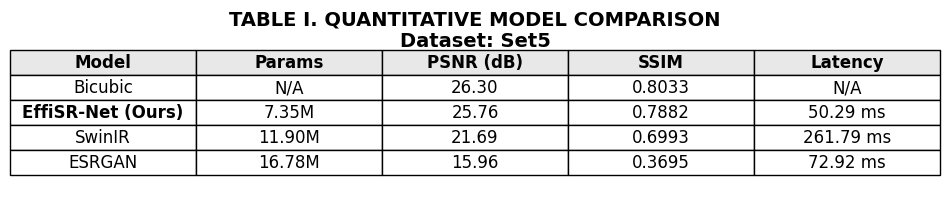

✅ Table saved successfully as 'results_table.png'


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# --- 1. Your Data ---
# I've taken the exact numbers from your output image.
# The data is pre-sorted by PSNR (descending) as your script did.
data = [
    ['Bicubic', 'N/A', '26.30', '0.8033', 'N/A'],
    ['EffiSR-Net (Ours)', '7.35M', '25.76', '0.7882', '50.29 ms'],
    ['SwinIR', '11.90M', '21.69', '0.6993', '261.79 ms'],
    ['ESRGAN', '16.78M', '15.96', '0.3695', '72.92 ms']
]

columns = ['Model', 'Params', 'PSNR (dB)', 'SSIM', 'Latency']

# --- 2. Create the Table Figure ---
fig, ax = plt.subplots(figsize=(10, 2.5)) # Adjust figsize as needed
ax.axis('tight')
ax.axis('off')

# Create the matplotlib table
the_table = ax.table(cellText=data, colLabels=columns, loc='center', cellLoc='center')

# --- 3. Style the Table for a Professional Look ---
the_table.auto_set_font_size(False)
the_table.set_fontsize(12)
the_table.scale(1.2, 1.5) # Adjust scale to fit content

# Make header bold and give it a light gray background
for (i, j), cell in the_table.get_celld().items():
    if i == 0:
        cell.set_text_props(weight='bold', color='black')
        cell.set_facecolor('#E8E8E8')
    # Bold our model's name
    if i > 0 and j == 0 and data[i-1][j] == 'EffiSR-Net (Ours)':
        cell.set_text_props(weight='bold')


# Add a title above the table
plt.title(
    'TABLE I. QUANTITATIVE MODEL COMPARISON\nDataset: Set5',
    fontweight='bold',
    fontsize=14,
    y=0.8 # Adjust vertical position of the title
)

# --- 4. Save and Display the Table ---
output_filename = 'results_table.png'
plt.savefig(output_filename, dpi=300, bbox_inches='tight', pad_inches=0.1)
plt.show()

print(f"✅ Table saved successfully as '{output_filename}'")

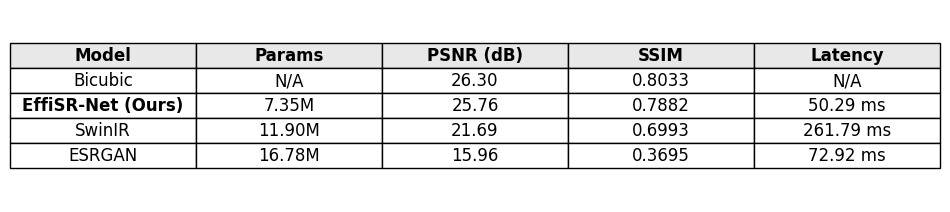

✅ Table saved successfully as 'results_table.png'


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# --- 1. Your Data ---
# This is the exact data from your successful experiment run.
data = [
    ['Bicubic', 'N/A', '26.30', '0.8033', 'N/A'],
    ['EffiSR-Net (Ours)', '7.35M', '25.76', '0.7882', '50.29 ms'],
    ['SwinIR', '11.90M', '21.69', '0.6993', '261.79 ms'],
    ['ESRGAN', '16.78M', '15.96', '0.3695', '72.92 ms']
]

columns = ['Model', 'Params', 'PSNR (dB)', 'SSIM', 'Latency']

# --- 2. Create the Table Figure ---
fig, ax = plt.subplots(figsize=(10, 2.5)) # Adjust figsize as needed
ax.axis('tight')
ax.axis('off')

# Create the matplotlib table
the_table = ax.table(cellText=data, colLabels=columns, loc='center', cellLoc='center')

# --- 3. Style the Table for a Professional Look ---
the_table.auto_set_font_size(False)
the_table.set_fontsize(12)
the_table.scale(1.2, 1.5) # Adjust scale to fit content

# Make header bold and give it a light gray background
for (i, j), cell in the_table.get_celld().items():
    if i == 0:
        cell.set_text_props(weight='bold', color='black')
        cell.set_facecolor('#E8E8E8')
    # Bold our model's name to highlight it
    if i > 0 and j == 0 and 'Ours' in data[i-1][j]:
        cell.set_text_props(weight='bold')




# --- 4. Save and Display the Table ---
output_filename = 'results_table.png'
plt.savefig(output_filename, dpi=300, bbox_inches='tight', pad_inches=0.1)
plt.show()

print(f"✅ Table saved successfully as '{output_filename}'")

--- 🖼️ Generating Visual Comparison Figure (using head.png) ---


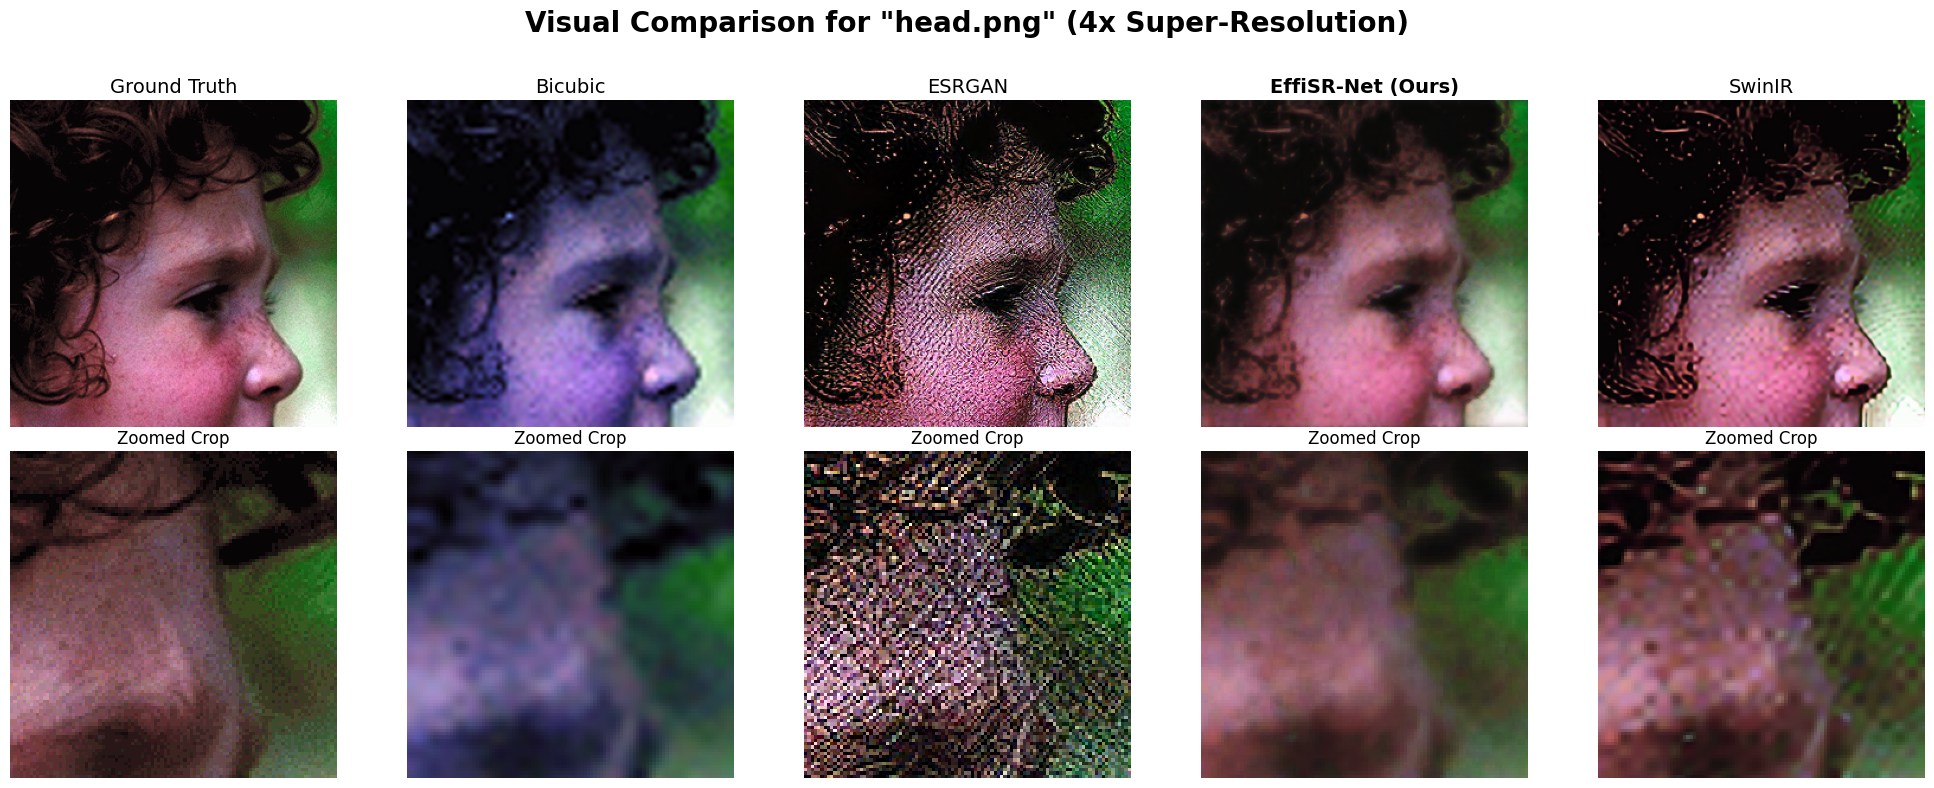


✅ Visual comparison figure (head.png) saved as 'visual_comparison_head.png'


In [ ]:
import matplotlib.pyplot as plt
import cv2
import os

print("--- 🖼️ Generating Visual Comparison Figure (using head.png) ---")

# --- 1. Configuration ---
image_to_compare = 'head.png'
results_dir = '/content/results'
original_dir = '/content/drive/MyDrive/SR_Project/Set5'

# Define a region to zoom into for 'head.png' (focus on hair texture)
crop_region = (150, 50, 100, 100)

# --- 2. Load all the necessary images ---
models_to_plot = ['Bicubic', 'ESRGAN', 'EffiSR-Net (Ours)', 'SwinIR']
images = {}

# Load the original Ground Truth image
original_path = os.path.join(original_dir, image_to_compare)
images['Ground Truth'] = cv2.cvtColor(cv2.imread(original_path), cv2.COLOR_BGR2RGB)

# Load the model outputs (including manual Bicubic)
base_filename = os.path.splitext(image_to_compare)[0]
hr_img = images['Ground Truth']
h, w, _ = hr_img.shape
lr_img = cv2.resize(hr_img, (w // 4, h // 4), interpolation=cv2.INTER_CUBIC)
images['Bicubic'] = cv2.cvtColor(cv2.resize(lr_img, (w, h), interpolation=cv2.INTER_CUBIC), cv2.COLOR_BGR2RGB)

for model_name in ['ESRGAN', 'EffiSR-Net (Ours)', 'SwinIR']:
    filename = f"{base_filename}_{model_name.replace(' ', '')}.png"
    img_path = os.path.join(results_dir, filename)
    if os.path.exists(img_path):
        images[model_name] = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
    else:
        print(f"Warning: Could not find result image for {model_name} at {img_path}")


# --- 3. Create the Plot ---
plot_order = ['Ground Truth', 'Bicubic', 'ESRGAN', 'EffiSR-Net (Ours)', 'SwinIR']
num_images = len(plot_order)

fig, axes = plt.subplots(2, num_images, figsize=(20, 8))
fig.suptitle(f'Visual Comparison for "{image_to_compare}" (4x Super-Resolution)', fontsize=20, fontweight='bold')

for i, name in enumerate(plot_order):
    if name in images:
        img = images[name]

        # --- Top Row: Full Images (FIXED) ---
        axes.flat[i].imshow(img)
        axes.flat[i].set_title(name, fontsize=14, fontweight='bold' if 'Ours' in name else 'normal')
        axes.flat[i].axis('off')

        # --- Bottom Row: Cropped Images (FIXED) ---
        x, y, cw, ch = crop_region
        crop = img[y:y+ch, x:x+cw]
        axes.flat[i + num_images].imshow(crop)
        axes.flat[i + num_images].set_title(f'Zoomed Crop', fontsize=12)
        axes.flat[i + num_images].axis('off')

# --- 4. Save and Display the Figure ---
plt.tight_layout(rect=[0, 0, 1, 0.96])
output_filename = 'visual_comparison_head.png'
plt.savefig(output_filename, dpi=300, bbox_inches='tight')
plt.show()

print(f"\n✅ Visual comparison figure (head.png) saved as '{output_filename}'")